In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_A = pd.read_csv('[Daytime]A.csv')
data_B = pd.read_csv('[Daytime]B.csv')

#drop unnecessary columns
data_A.drop(columns=['Unnamed: 0'],inplace=True)
data_B.drop(columns=['Unnamed: 0'],inplace=True)

#changing date column to datetime data type
data_A['date'] = pd.to_datetime(data_A['date'])
data_B['date'] = pd.to_datetime(data_B['date'])


In [3]:
#change date time data to the form year-month-day-hour for appropriate generalization
data_A['date_hour'] = data_A['date'].dt.strftime('%Y %m %d %H')
data_A['date_hour'] = pd.to_datetime(data_A['date_hour'])
data_B['date_hour'] = data_B['date'].dt.strftime('%Y %m %d %H')
data_B['date_hour'] = pd.to_datetime(data_B['date_hour'])

#add source for each dataset
data_A['Source'] = "A"
data_B['Source'] = "B"

#drop unecessary metrics
data_A.drop(['index1','index2'], axis=1, inplace=True)
data_B.drop(['index1','index2'], axis=1, inplace=True)


In [4]:
#function to filter metrics 
def groupbydatehour(df, column):
    data = df.groupby('date_hour')[column].sum().reset_index()
    return data

# Univariate Analysis

In [5]:

#filter metrics in each dataset
dataA = []
for column in data_A.columns:
    if (column == 'date_hour') or (column =='date') or (column == 'Source'):
        continue
    dataA.append(groupbydatehour(data_A, column))

dataB = []
for column in data_B.columns:
    if (column == 'date_hour') or (column =='date')or (column == 'Source'):
        continue
    dataB.append(groupbydatehour(data_B, column))

for i in range (len(dataA)):
    dataA[i]['Source'] = 'DataA'
    dataB[i]['Source'] = 'DataB'

In [6]:
#function to draw interactive line plot
def plotlyplot(df):
    import plotly.express as px
    import pandas as pd
    fig = px.line(
        df, 
        x='date_hour', 
        y=df.columns[1], 
        color='Source',  
        title= df.columns[1] + " vs Date hour"
    )
    fig.update_xaxes(type='category')
    # Show the figure
    fig.show()

In [7]:
#function for line plot
def lineplot(dataset1, dataset2,col):
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 30))
    axes = axes.flatten()
    for i in range(len(dataset1)):
        ax = axes[i]
        ax.plot(dataset1[i][col], dataset1[i][dataset1[i].columns[1]], label = 'DatasetA')
        ax.plot(dataset2[i][col], dataset2[i][dataset2[i].columns[1]], label = 'DatasetB')
        ax.set_title(dataA[i].columns[1])
        ax.legend()
    plt.tight_layout()
    plt.show()

In [8]:
#function to summarize data with respect to day name
def get_day_name(dataset):
    new = []
    weekday_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

    for i in range(len(dataset)):
        dataset[i]['weekday_name'] = dataset[i]['date_hour'].dt.day_name()
        data = dataset[i].groupby(dataset[i]['weekday_name'])[dataset[i].columns[1]].mean().reset_index()
        data['weekday_int'] = data['weekday_name'].map(weekday_mapping)
        data = data.sort_values(by='weekday_int').drop(columns=['weekday_int'])        
        new.append(data)
    return new

In [9]:
#function to summarize data with respect to hour
def hour(dataset):
    new = []
    for i in range (len(dataset)):
        dataset[i]['date_hour'] = pd.to_datetime(dataset[i]['date_hour'])
        dataset[i]['hour'] = dataset[i]['date_hour'].dt.hour
        data = dataset[i].groupby(dataset[i]['hour'])[dataset[i].columns[1]].mean().reset_index()
        new.append(data)
    return new

In [10]:
#function to subset outliers
def outliers(df,column):
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3-q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    subset = df[(df[column]<upper)]
    return subset

In [11]:
#plot data in time order
df = []
for i in range (len(dataA)):
    combinedAB = pd.concat([dataA[i], dataB[i]])
    df.append(combinedAB)
for i in range (len(dataA)):
    plotlyplot(df[i])

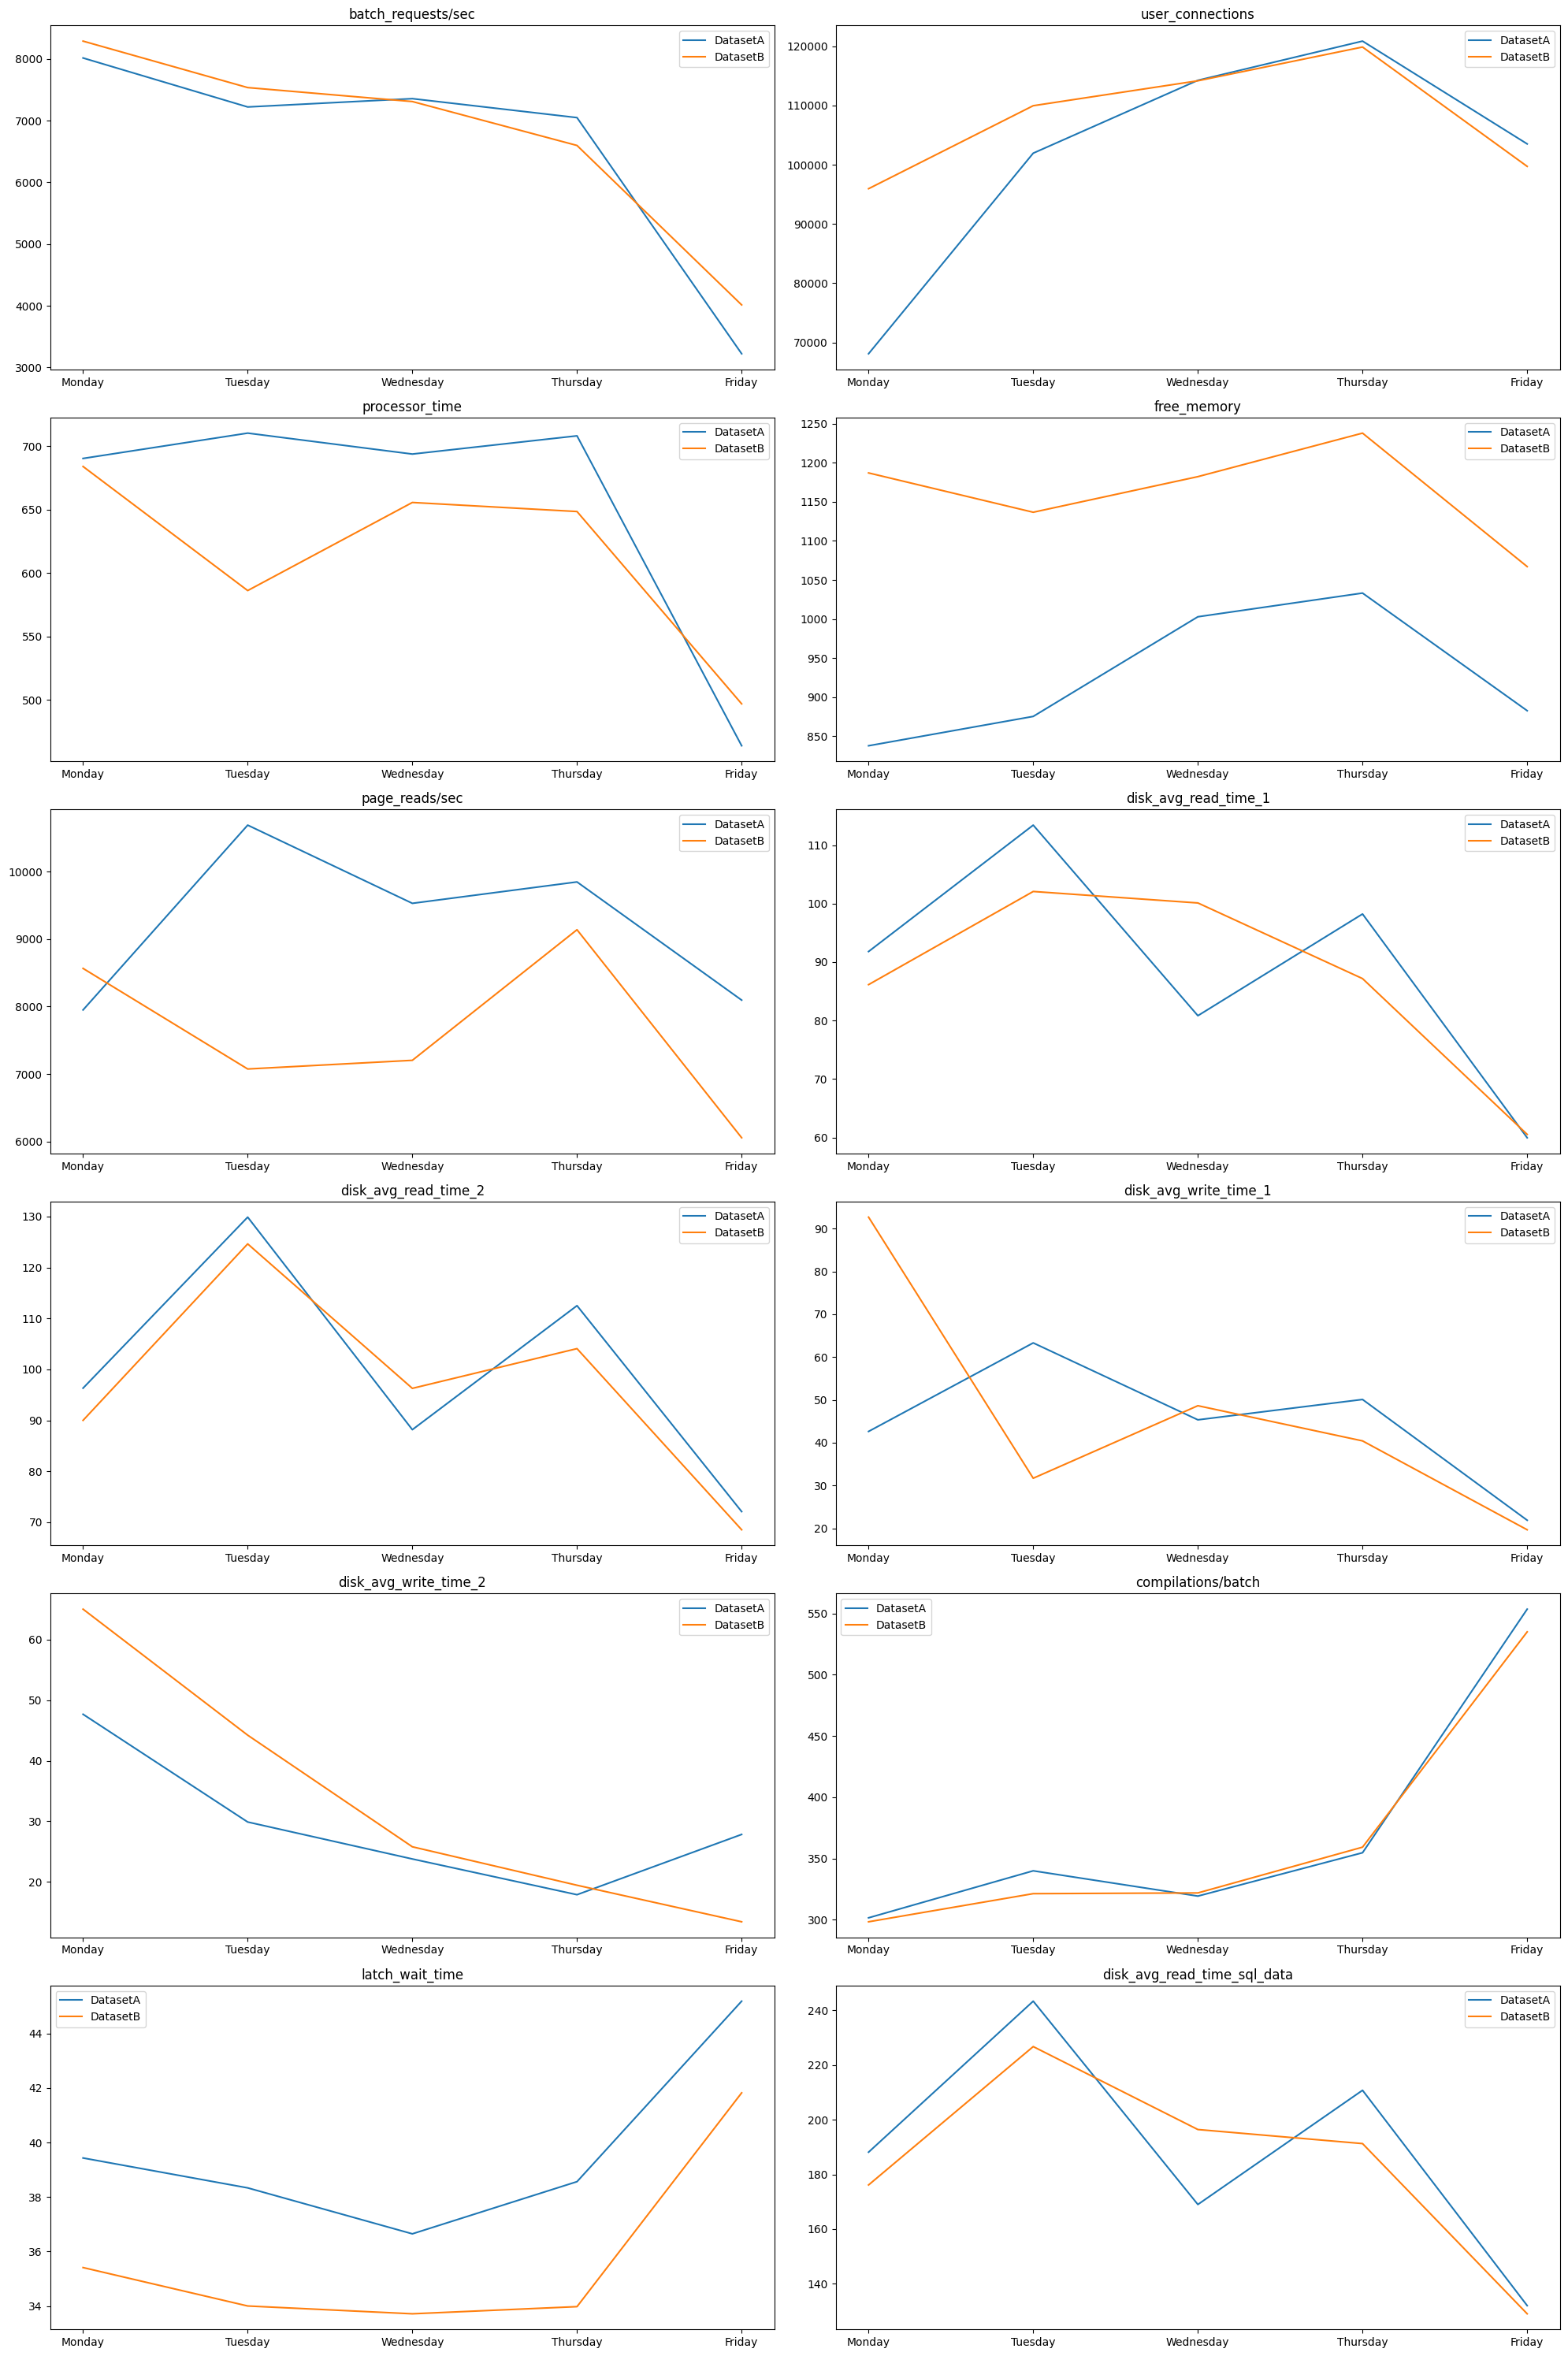

In [12]:
#plot data with respect to day name
data_weekdayA = get_day_name(dataA)
data_weekdayB = get_day_name(dataB)
lineplot(data_weekdayA, data_weekdayB, 'weekday_name')

### 1 Batch request and user_connections:
- For the workload, there is good similarity between `batch_request/sec` and `user_connections`, which make it fair to make comparison between two dataset's performance

### 2, Processor time:

- The plot shows that processor_time is consistently higher when maintenance is performed (Dataset A) compared to when it is off (Dataset B).
- This suggests that daily index maintenance might be contributing to increased CPU load, likely due to query recompilations and other maintenance-related activities.
- The lower processor_time in Dataset B across all days indicates that the server experiences less CPU load when maintenance is disabled. This could mean fewer recompilations and less CPU-intensive activities are happening.

### 3, Free memory:
- Dataset B shows consistently higher free memory compared to Dataset A, suggesting that stopping maintenance might be beneficial for memory management.
- Higher free memory could indicate less fragmentation or less intensive caching needs when maintenance is not performed frequently.

### 4, Page_read/sec
- The graph shows consistently higher page_reads/sec values for Dataset A compared to Dataset B, especially noticeable on Tuesday and Thursday.
- Dataset B shows significantly lower page_reads/sec values, which suggests that the server is able to handle read operations more efficiently when maintenance is disabled. This could be due to better data caching or less frequent reorganization of data pages.
The lower reads per second indicate that the server is relying more on cached data, which improves performance by reducing disk I/O operations.

### 5, Disk average read times:
- Dataset A shows noticeable peaks, especially on Tuesday and Thursday, indicating variability and higher read times when maintenance is on.
- Dataset B shows lower and more stable read times, indicating better disk performance without frequent index maintenance.

### 6, Disk average write times:
- Initial Performance Impact: Both graphs indicate that when maintenance is turned off, there is an initial increase in write times (especially noticeable on Monday).
- Long-Term Benefits: However, after the initial period, write times tend to stabilize and often improve compared to when maintenance is performed daily.

### 7, compilations/ batch
- There is no distinct difference between 2 datasets 

### 8, latch wait time 
- Dataset B shows significantly lower latch wait times throughout the week, indicating more efficient internal operations when maintenance is turned off.
- The lower wait times suggest that the server experiences fewer delays in accessing resources, possibly because maintenance-related overhead is reduced.


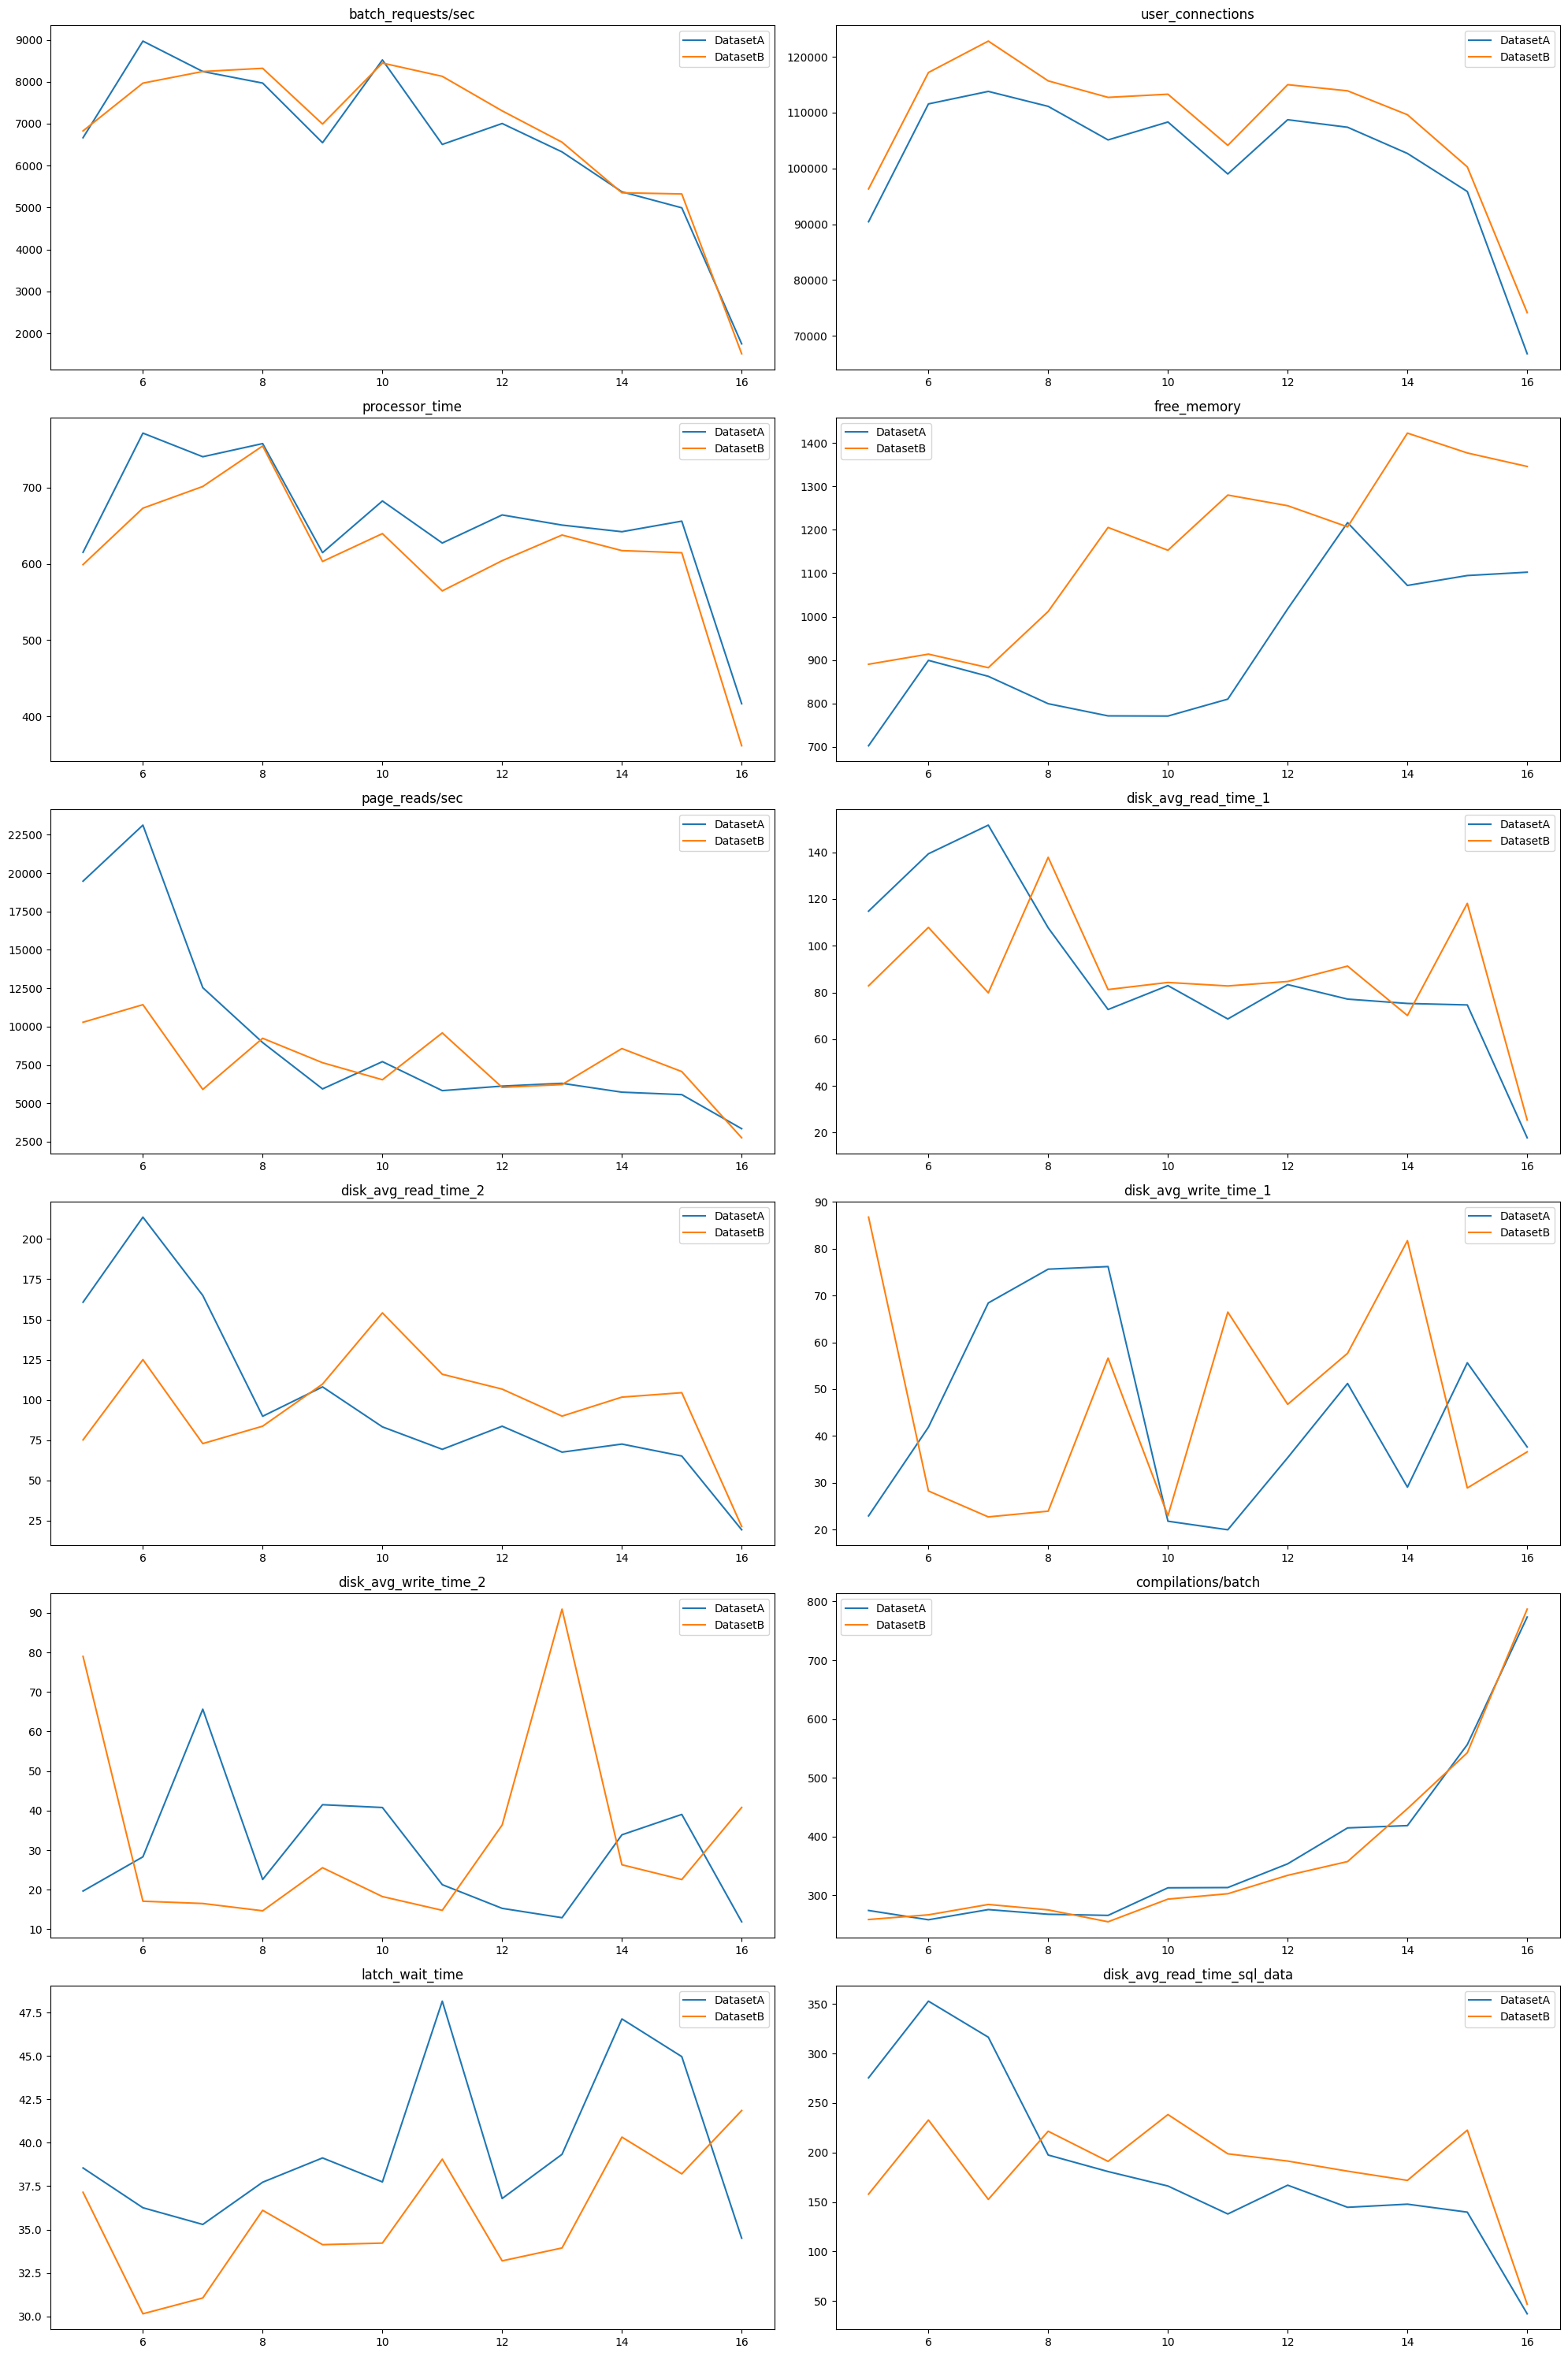

In [13]:
#plot data with respect to hour 
data_hour_A = hour(dataA)
data_hour_B = hour(dataB)
lineplot(data_hour_A, data_hour_B,'hour')

### 1, Processor Time:
- Peaks in Early Hours with Maintenance (Dataset A): There are notable peaks in CPU usage during early hours, indicating that maintenance activities are causing spikes in CPU demand.
- Other than that, dataset A and B have the same pattern throughout the day with a little bit better in the performance in processor time of dataset B. However, we still need to conduct
statistical test to decide whether this difference is important or not

### 2, Free Memory:
- There's a noticeable divergence between Dataset A and Dataset B starting from hour 8, with Dataset B maintaining or increasing free memory while Dataset A shows a decline. This suggests that Dataset B might be managing memory more effectively or experiencing lighter workloads.
- Dataset B consistently shows higher free memory throughout the observed hours, especially notable from hour 8 onwards, where the difference becomes more pronounced.


### 3, Page read per second:
- Both datasets show a sharp decrease in page reads per second after hour 8, stabilizing after hour 12
- Data A have a higher amount at the start of the day, which may be the result of rebuilding index at the beginning of the day, so that they have to read data/ index from pages
- However, after 8 pages read per second in dataset A seems to be more stable than that in dataset B   
- After rebuilding index, pages read per second in the dataset A indicates that the use of index for queries become more optimized and efficient, reducing the number of disk reads needed

### 4, Disk average read time:
- Initial Improvement Followed by Convergence: Dataset B initially shows lower read times compared to Dataset A, reflecting better performance without early maintenance. However, this advantage reduces later in the observed period, with read times converging or even exceeding those of Dataset A after hour 8.
- The analysis highlights that turning off index maintenance yields immediate improvements in disk read performance, particularly in the early hours. However, the benefits taper off later, indicating potential accumulating inefficiencies that could affect performance.

### 5, Disk average write time:
- High Initial Write Time in Dataset B: Dataset B (maintenance OFF) starts with a significantly higher write time in the early hour, which drops sharply afterward. This initial peak suggests that early in the period, write operations might face higher latency when maintenance is turned off, possibly due to initial data restructuring or lack of optimization.
- Increased Variability in Dataset B: Throughout the observed hours, Dataset B shows substantial fluctuations, with peaks that exceed those in Dataset A. This variability indicates that while turning off maintenance may sometimes reduce write times, it also introduces periods of increased latency, suggesting a less predictable performance profile.

### 6, compilations/ batch: 
- There is no distinct difference between 2 datasets 

### 7, latch wait time:
- Dataset A generally shows higher latch wait times, particularly noticeable with the significant peak around hour 11. This suggests that regular maintenance might contribute to increased contention for resources, leading to longer latch wait times.
- The variability observed in Dataset A implies that the impact of maintenance on latch wait times is not constant, with certain periods experiencing pronounced spikes.



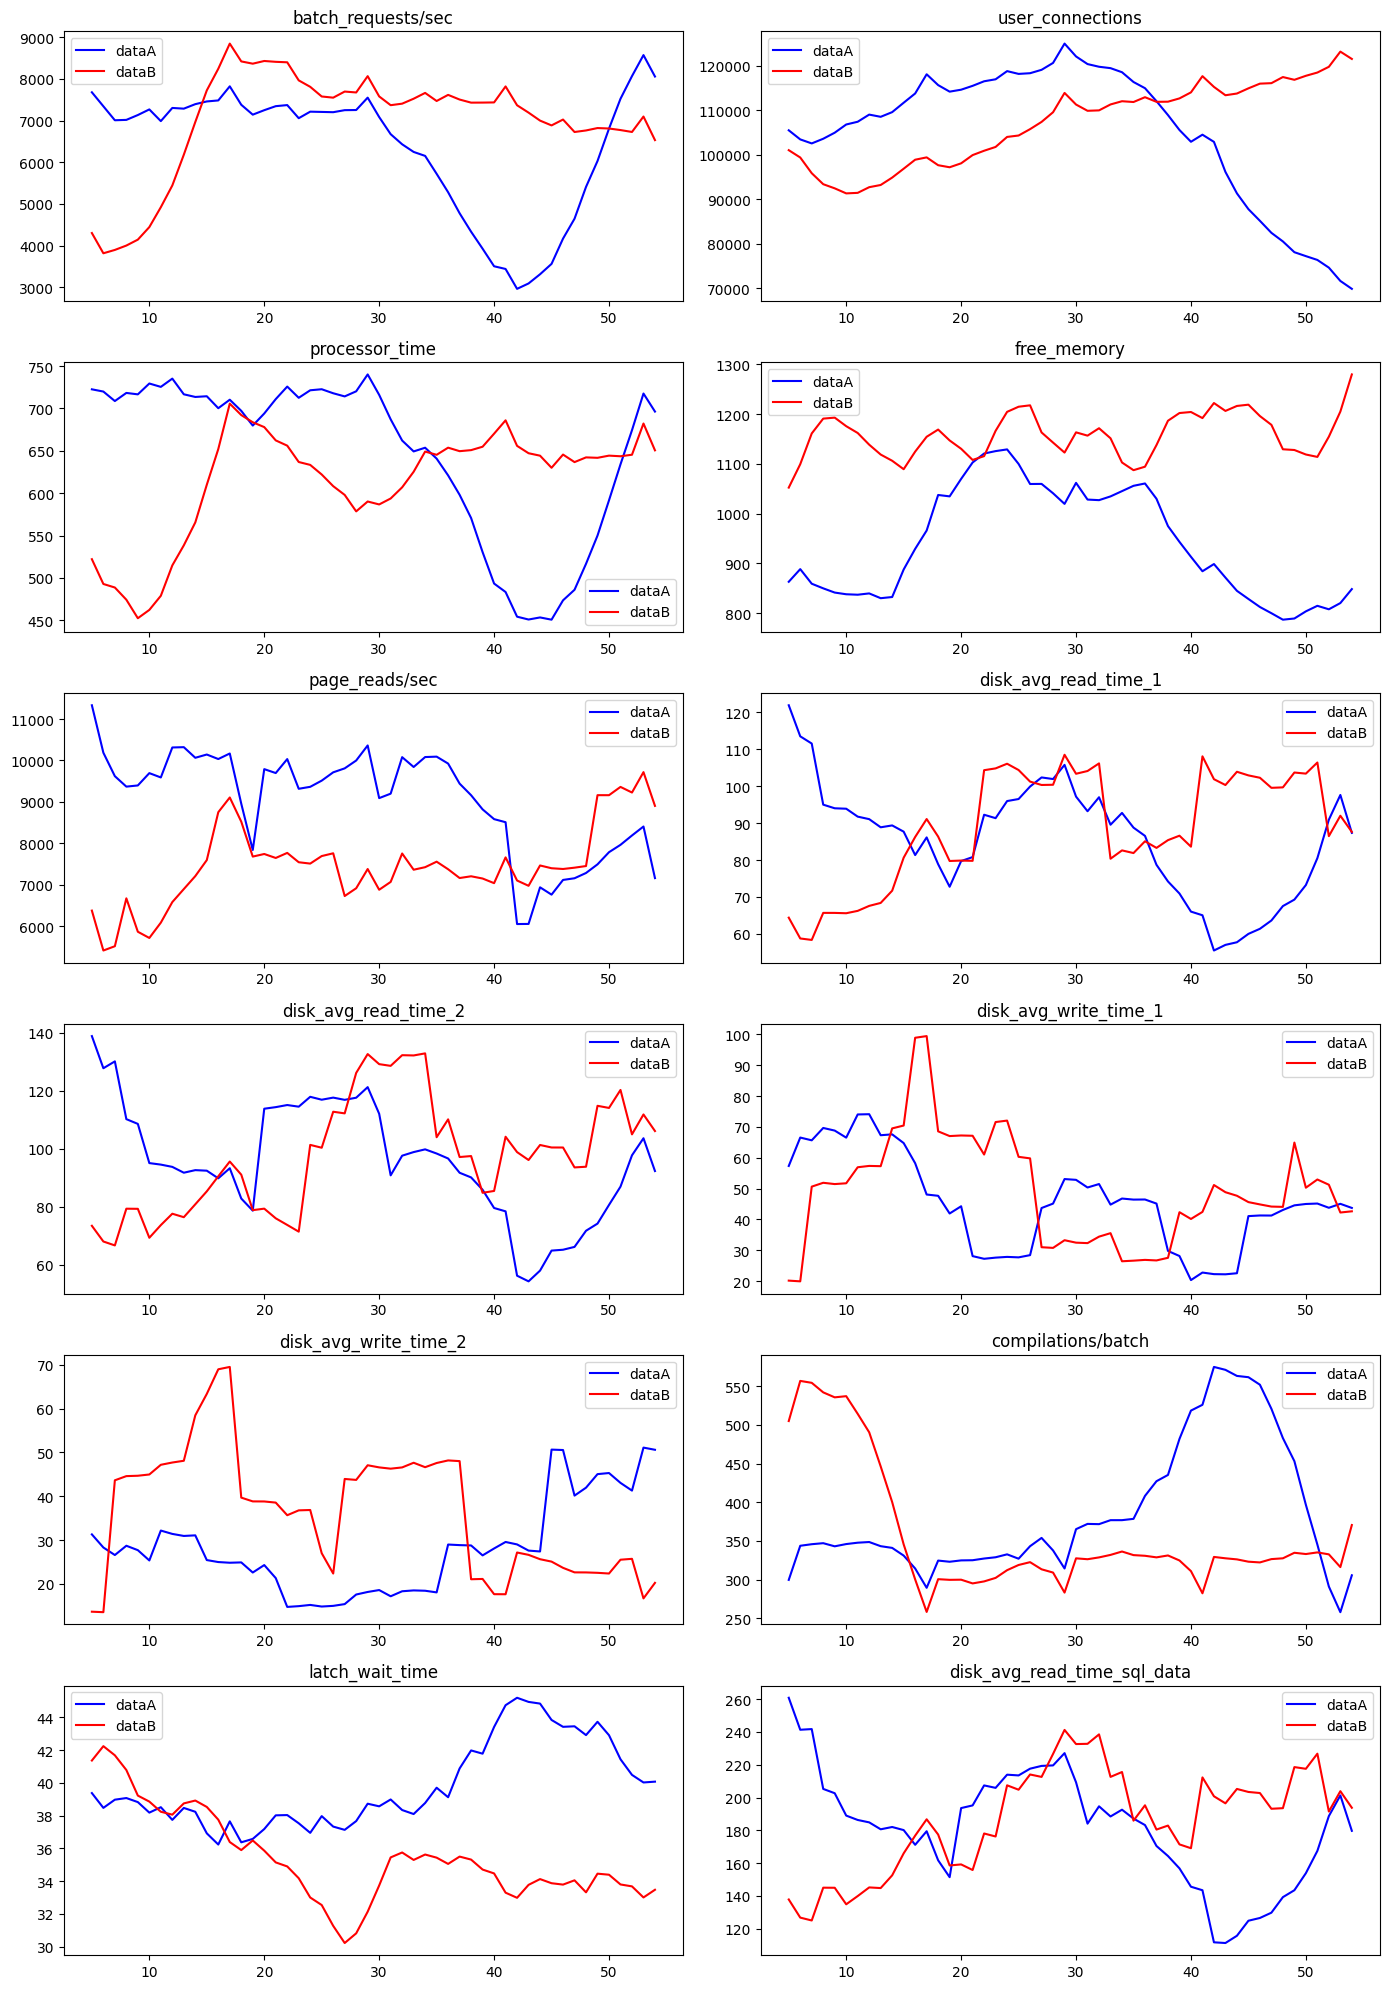

In [14]:

#function to plot trends of 2 dataset
from statsmodels.tsa.seasonal import seasonal_decompose

def trendplot(df1, df2, ax):

    decomp_a = seasonal_decompose(df1[df1.columns[1]], model='additive', period=11)
    decomp_b = seasonal_decompose(df2[df2.columns[1]], model='additive', period=11)

    ax.plot(decomp_a.trend, label='dataA', color='blue')
    ax.plot(decomp_b.trend, label='dataB', color='red')
    ax.legend()

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14, 20))
axes = axes.flatten()

for i in range(len(dataA)):
    ax = axes[i]
    trendplot(dataA[i], dataB[i], ax)  
    ax.set_title(dataA[i].columns[1])

plt.tight_layout()
plt.show()

### 1, Processor time:
- Dataset A (blue line) shows more variability with clear peaks and troughs, indicating that maintenance activities may periodically increase CPU demand.

### 2, Free memory: 
- Dataset B shows consistently higher free memory, suggesting that without frequent maintenance, memory usage is more predictable and less burdened by maintenance-related tasks.

### 3, pages read/sec:

- Dataset A shows consistently higher page reads per second, especially noticeable in the initial periods. This suggests that with maintenance ON, the system is performing more disk reads, potentially due to fragmented data and less efficient access paths created by ongoing maintenance activities.
- Dataset B generally exhibits lower values for page_reads/sec, especially during the earlier part of the observed period. This lower disk read activity suggests that without frequent maintenance, the system might be relying more on cached data or experiencing fewer fragmented reads, thereby reducing the need for physical disk access.
- However, as the period progresses, Dataset B shows a slight upward trend, which could imply that over time, the absence of maintenance might start affecting disk efficiency, albeit less drastically than expected.

### 4, Disk average read time:
- Across all three graphs, Dataset A generally starts with higher read times compared to Dataset B. This suggests that maintenance activities initially introduce some overhead, leading to slower read performance at the beginning of the period.
- As time progresses, the read times between Dataset A and Dataset B tend to converge, with several instances of overlapping performance. This indicates that the impact of maintenance diminishes over time, and other factors may become more significant in determining disk read performance.
- Dataset B shows more variability and occasional peaks, especially in the later periods. This suggests that while turning off maintenance can initially improve read times, it may lead to less predictable performance, with occasional spikes in read times indicating potential instability.

### 5, Disk average write time:
- Both graphs show higher write times at the start when maintenance is turned off, indicating potential performance issues and instability early on without regular optimization.
- Over time, the write times in both Dataset A (Maintenance ON) and Dataset B converge, with Dataset B occasionally showing sharp peaks. This suggests that while maintenance initially helps stabilize performance, its impact may lessen as time progresses.
- Regular maintenance leads to a more consistent and stable write performance, reducing the frequency and magnitude of spikes compared to Dataset B, which shows more variability.

### 6, compilation/batch:
- Dataset B (red line) starts with significantly higher compilations per batch, indicating a higher CPU overhead early in the period when maintenance is turned off. This suggests that turning off maintenance could initially lead to more frequent query recompilations, possibly due to less optimized indexes.
- As the period progresses, the number of compilations in Dataset B decreases and stabilizes at a lower level than Dataset A. This indicates that, after the initial period, the impact of turning off maintenance lessens, and the system stabilizes with fewer compilations per batch.
- Dataset A (blue line) shows more compilations per batch in the mid to late period, suggesting that regular maintenance may lead to sustained query recompilations, possibly due to index reorganizations and data changes requiring frequent optimization.

### 7, latch wait time:
- Dataset A (blue line) shows consistently higher latch wait times, especially in the later period. This suggests that regular maintenance could be contributing to increased internal contention, possibly due to frequent data reorganizations or index updates that intensify resource access conflicts.
- Dataset B (red line) exhibits lower latch wait times, with a noticeable decreasing trend in the first half of the period. This indicates that turning off maintenance reduces internal contention, leading to smoother operations with fewer waits.
- The trends diverge significantly after the mid-period, with Dataset A’s latch wait times increasing while Dataset B maintains lower, more stable levels. This divergence highlights a potential long-term benefit of reduced maintenance in managing resource access efficiently.


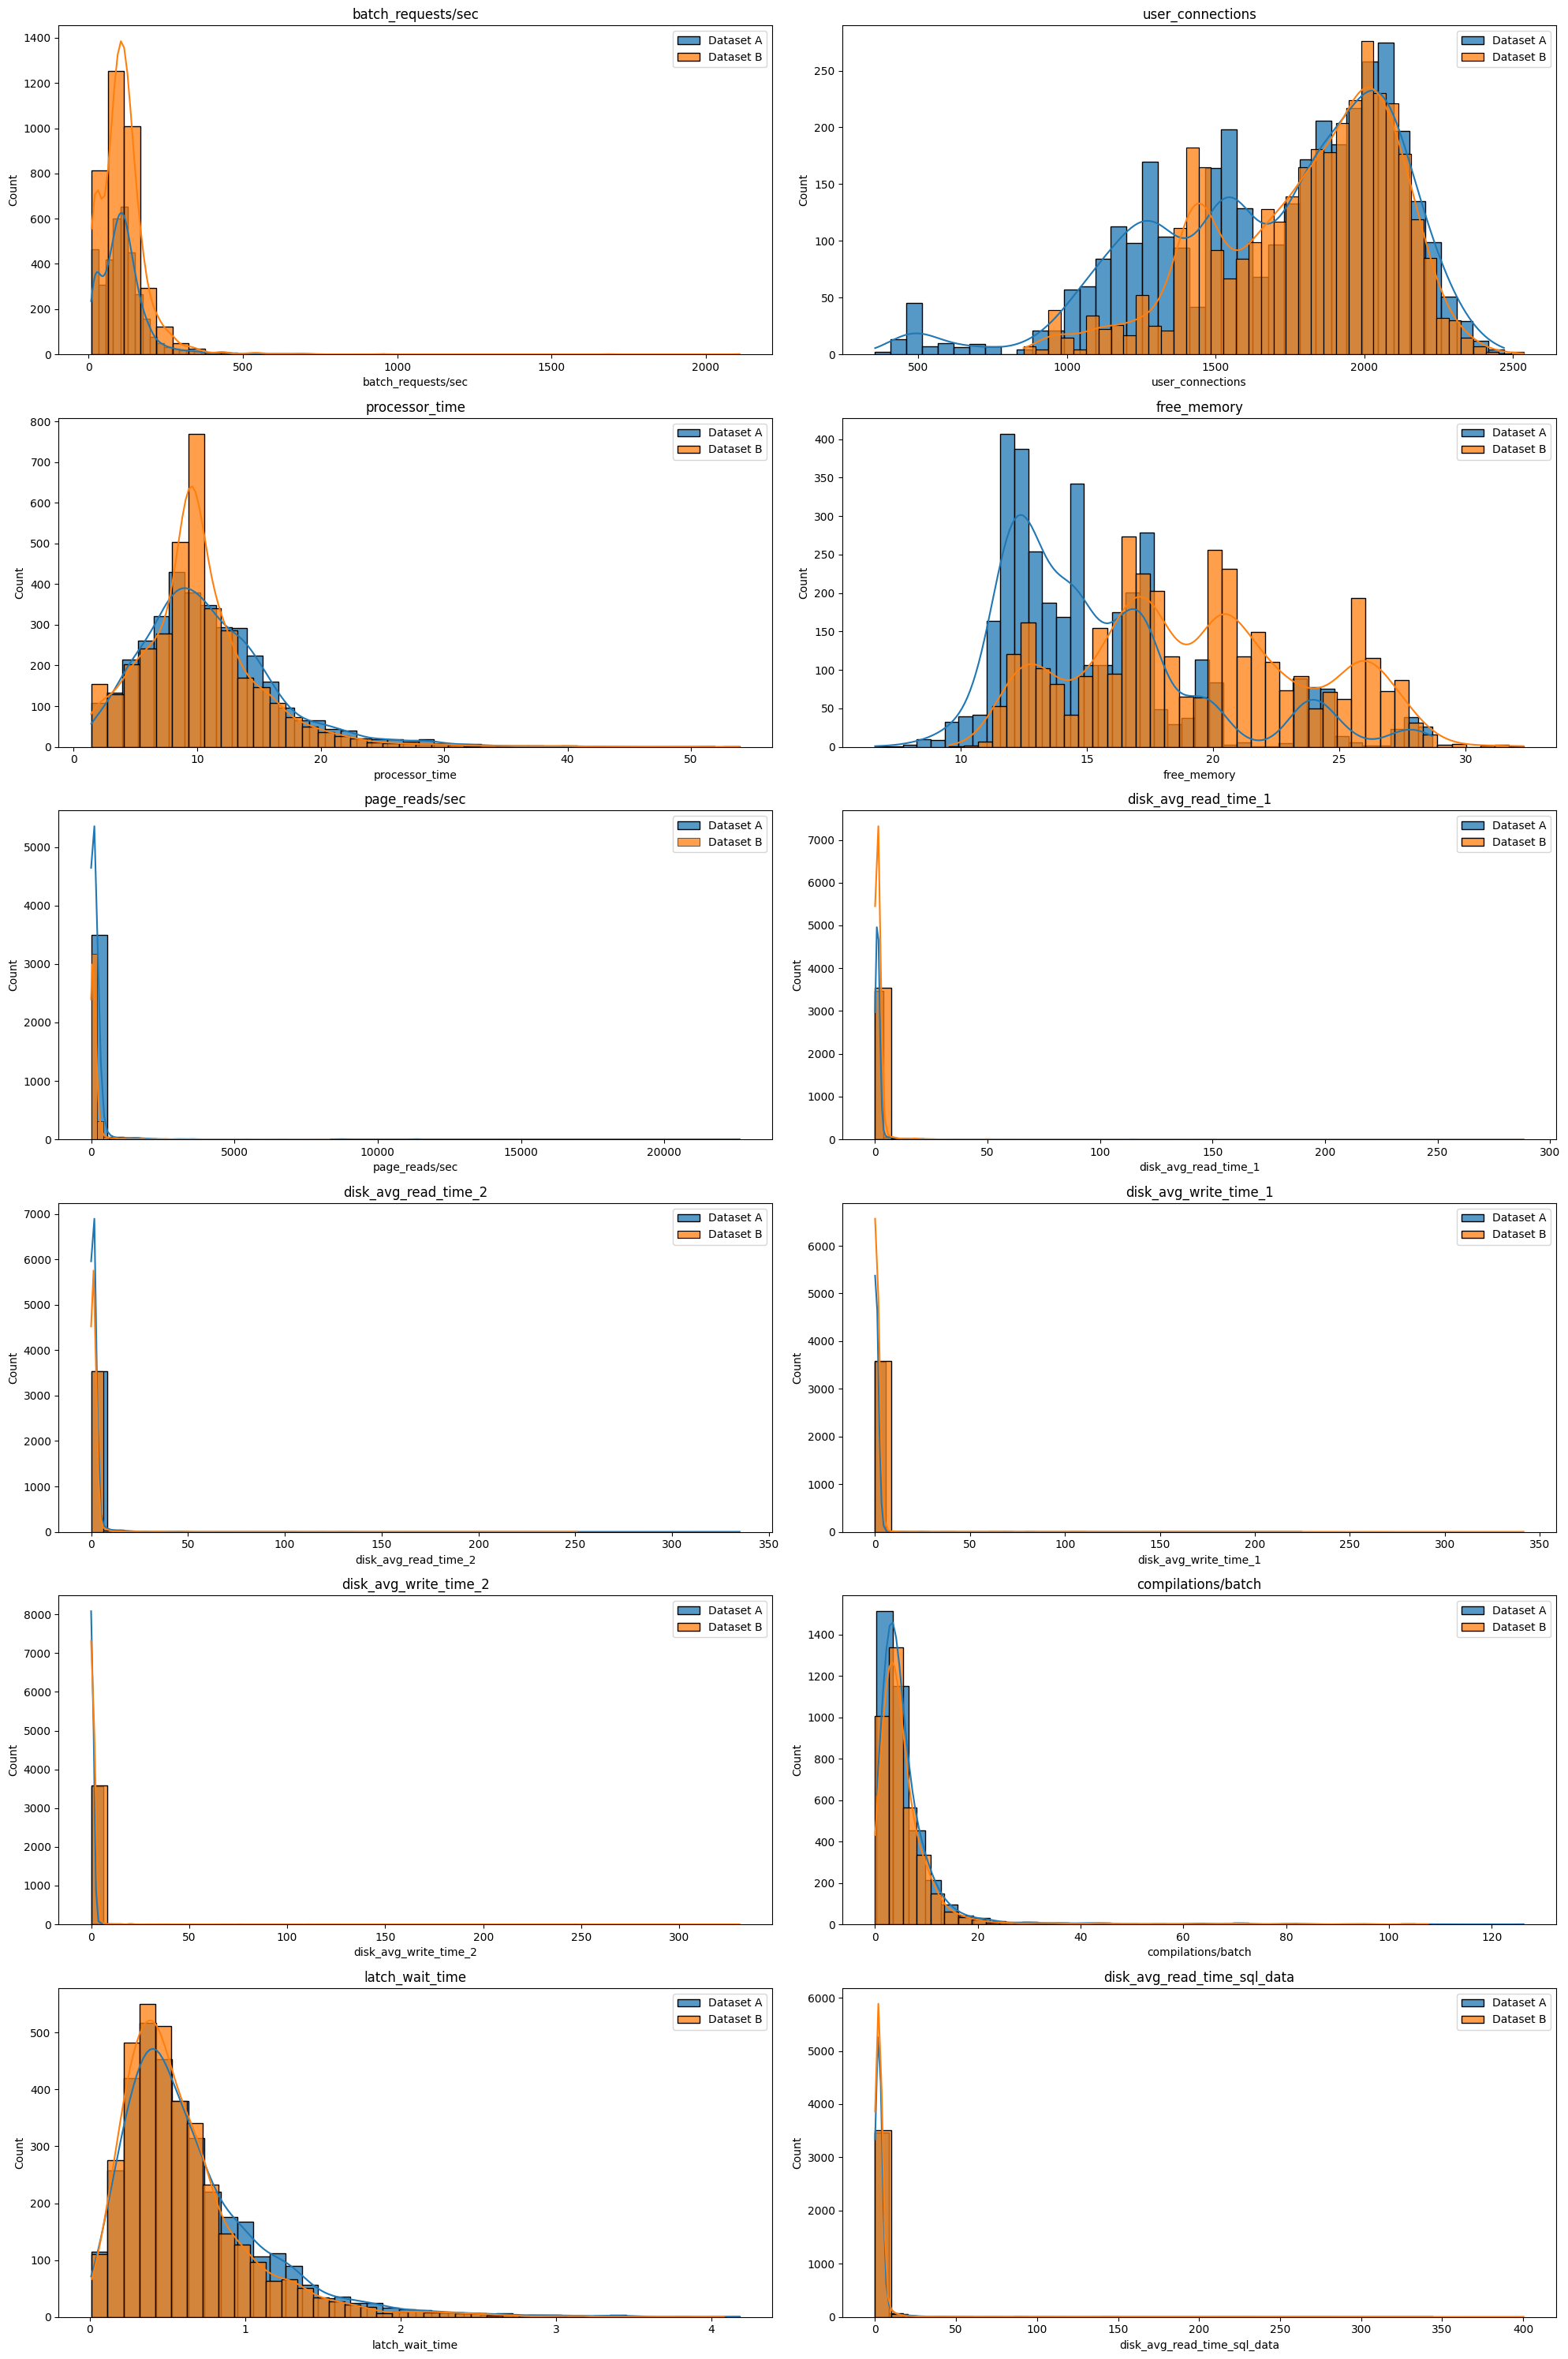

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 30))
axes = axes.flatten()

for i in range (len(dataA)):
    ax = axes[i]
    sns.histplot(data=data_A, x=dataA[i].columns[1], alpha=0.75, label='Dataset A', bins=40, kde=True, ax=ax)    
    sns.histplot(data=data_B, x=dataB[i].columns[1], alpha=0.75, label='Dataset B', bins=40, kde=True, ax=ax)    
    ax.set_title(dataA[i].columns[1])
    ax.legend()
plt.tight_layout()
plt.show()

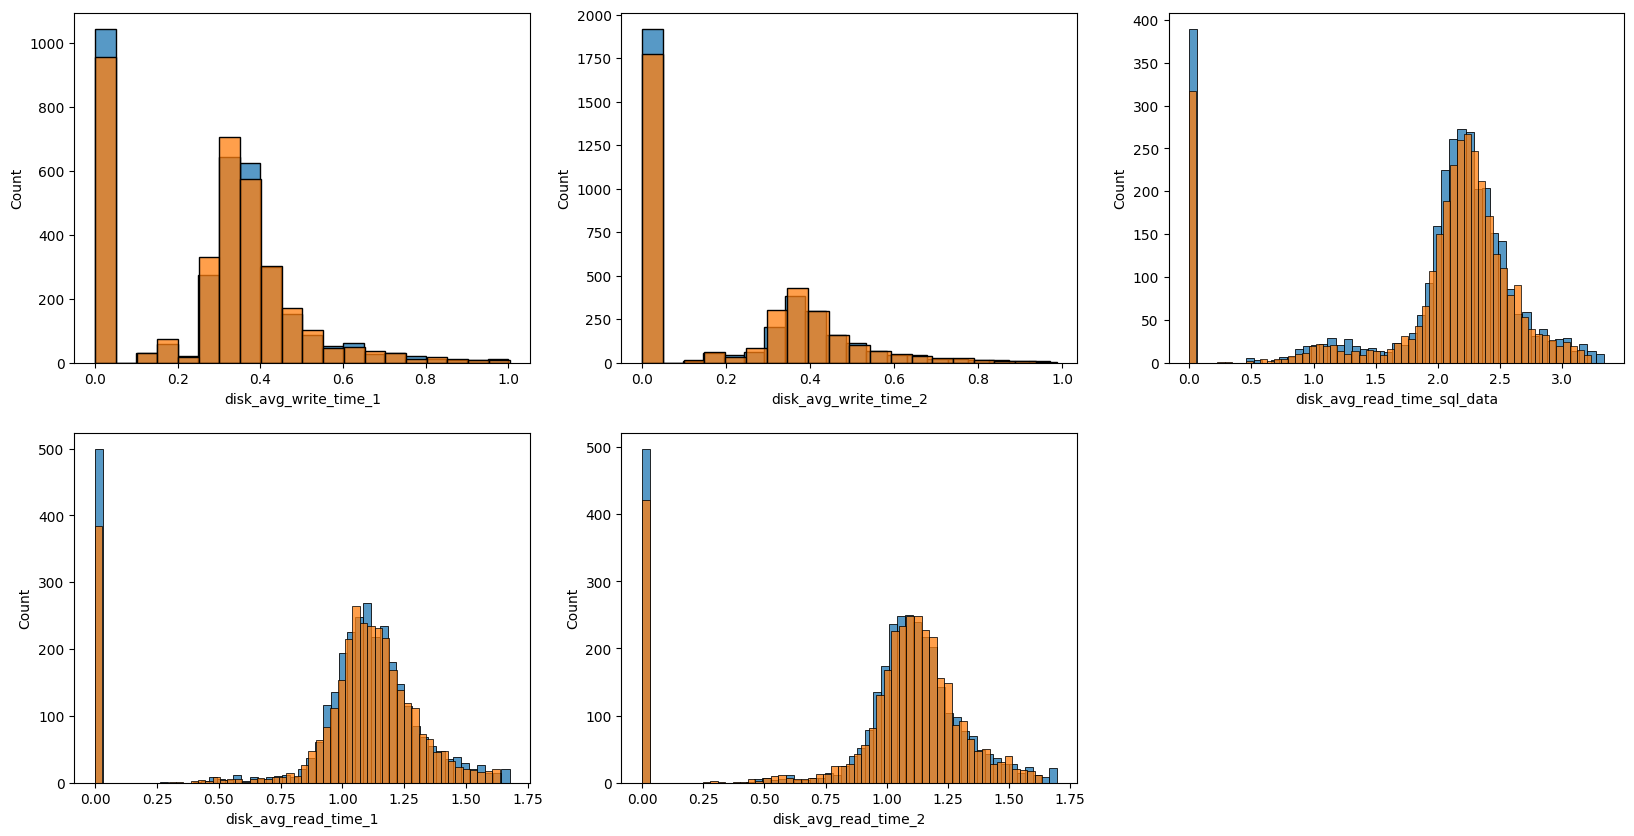

In [16]:
outliers_list = ['disk_avg_write_time_1', 'disk_avg_write_time_2','disk_avg_read_time_sql_data' , 'disk_avg_read_time_1','disk_avg_read_time_2' ]
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,10))
axes = axes.flatten()
for i in range(5):
    subset1 = outliers(data_A, outliers_list[i])
    subset2 = outliers(data_B, outliers_list[i])
    sns.histplot(data=subset1, x =outliers_list[i], ax=axes[i],alpha=0.75)
    sns.histplot(data=subset2 ,x = outliers_list[i], ax=axes[i],alpha=0.75)
fig.delaxes(axes[-1])

### 1, Processor time:
- Dataset B (orange) has a higher concentration of low processor_time values, indicating that turning off maintenance tends to reduce CPU usage overall. The peak is centered around lower values compared to Dataset A, suggesting more efficient CPU usage without maintenance tasks running frequently.
- Dataset A (blue) shows a broader spread of processor_time, with more frequent higher values. This reflects the additional CPU load caused by maintenance activities, leading to a wider range of CPU consumption.

### 2, Free memory: 
- Dataset B consistently shows higher concentration around higher free memory values, indicating that without frequent maintenance, more memory is available. This suggests reduced memory overhead when maintenance is turned off.
- Dataset A’s distribution is more skewed towards lower memory values, reflecting the impact of maintenance activities that consume additional memory resources. 

### 3, compilations/batch:
- There is no distinct difference

### 4, latch wait time:
- Dataset B (orange) shows a higher concentration of very low latch wait times near zero, indicating that turning off maintenance generally reduces contention within the system. This suggests a smoother, more efficient process flow with fewer delays when maintenance tasks are not frequently interrupting operations.
- Dataset A (blue) has a wider spread, with more instances of higher latch wait times. This broader distribution indicates that regular maintenance introduces variability and increases contention, leading to longer wait times for processes during peak maintenance activities.
- While both datasets overlap significantly at low wait times, Dataset A’s peak is lower and distribution extends further right, reflecting the overhead and variability introduced by frequent maintenance activities.


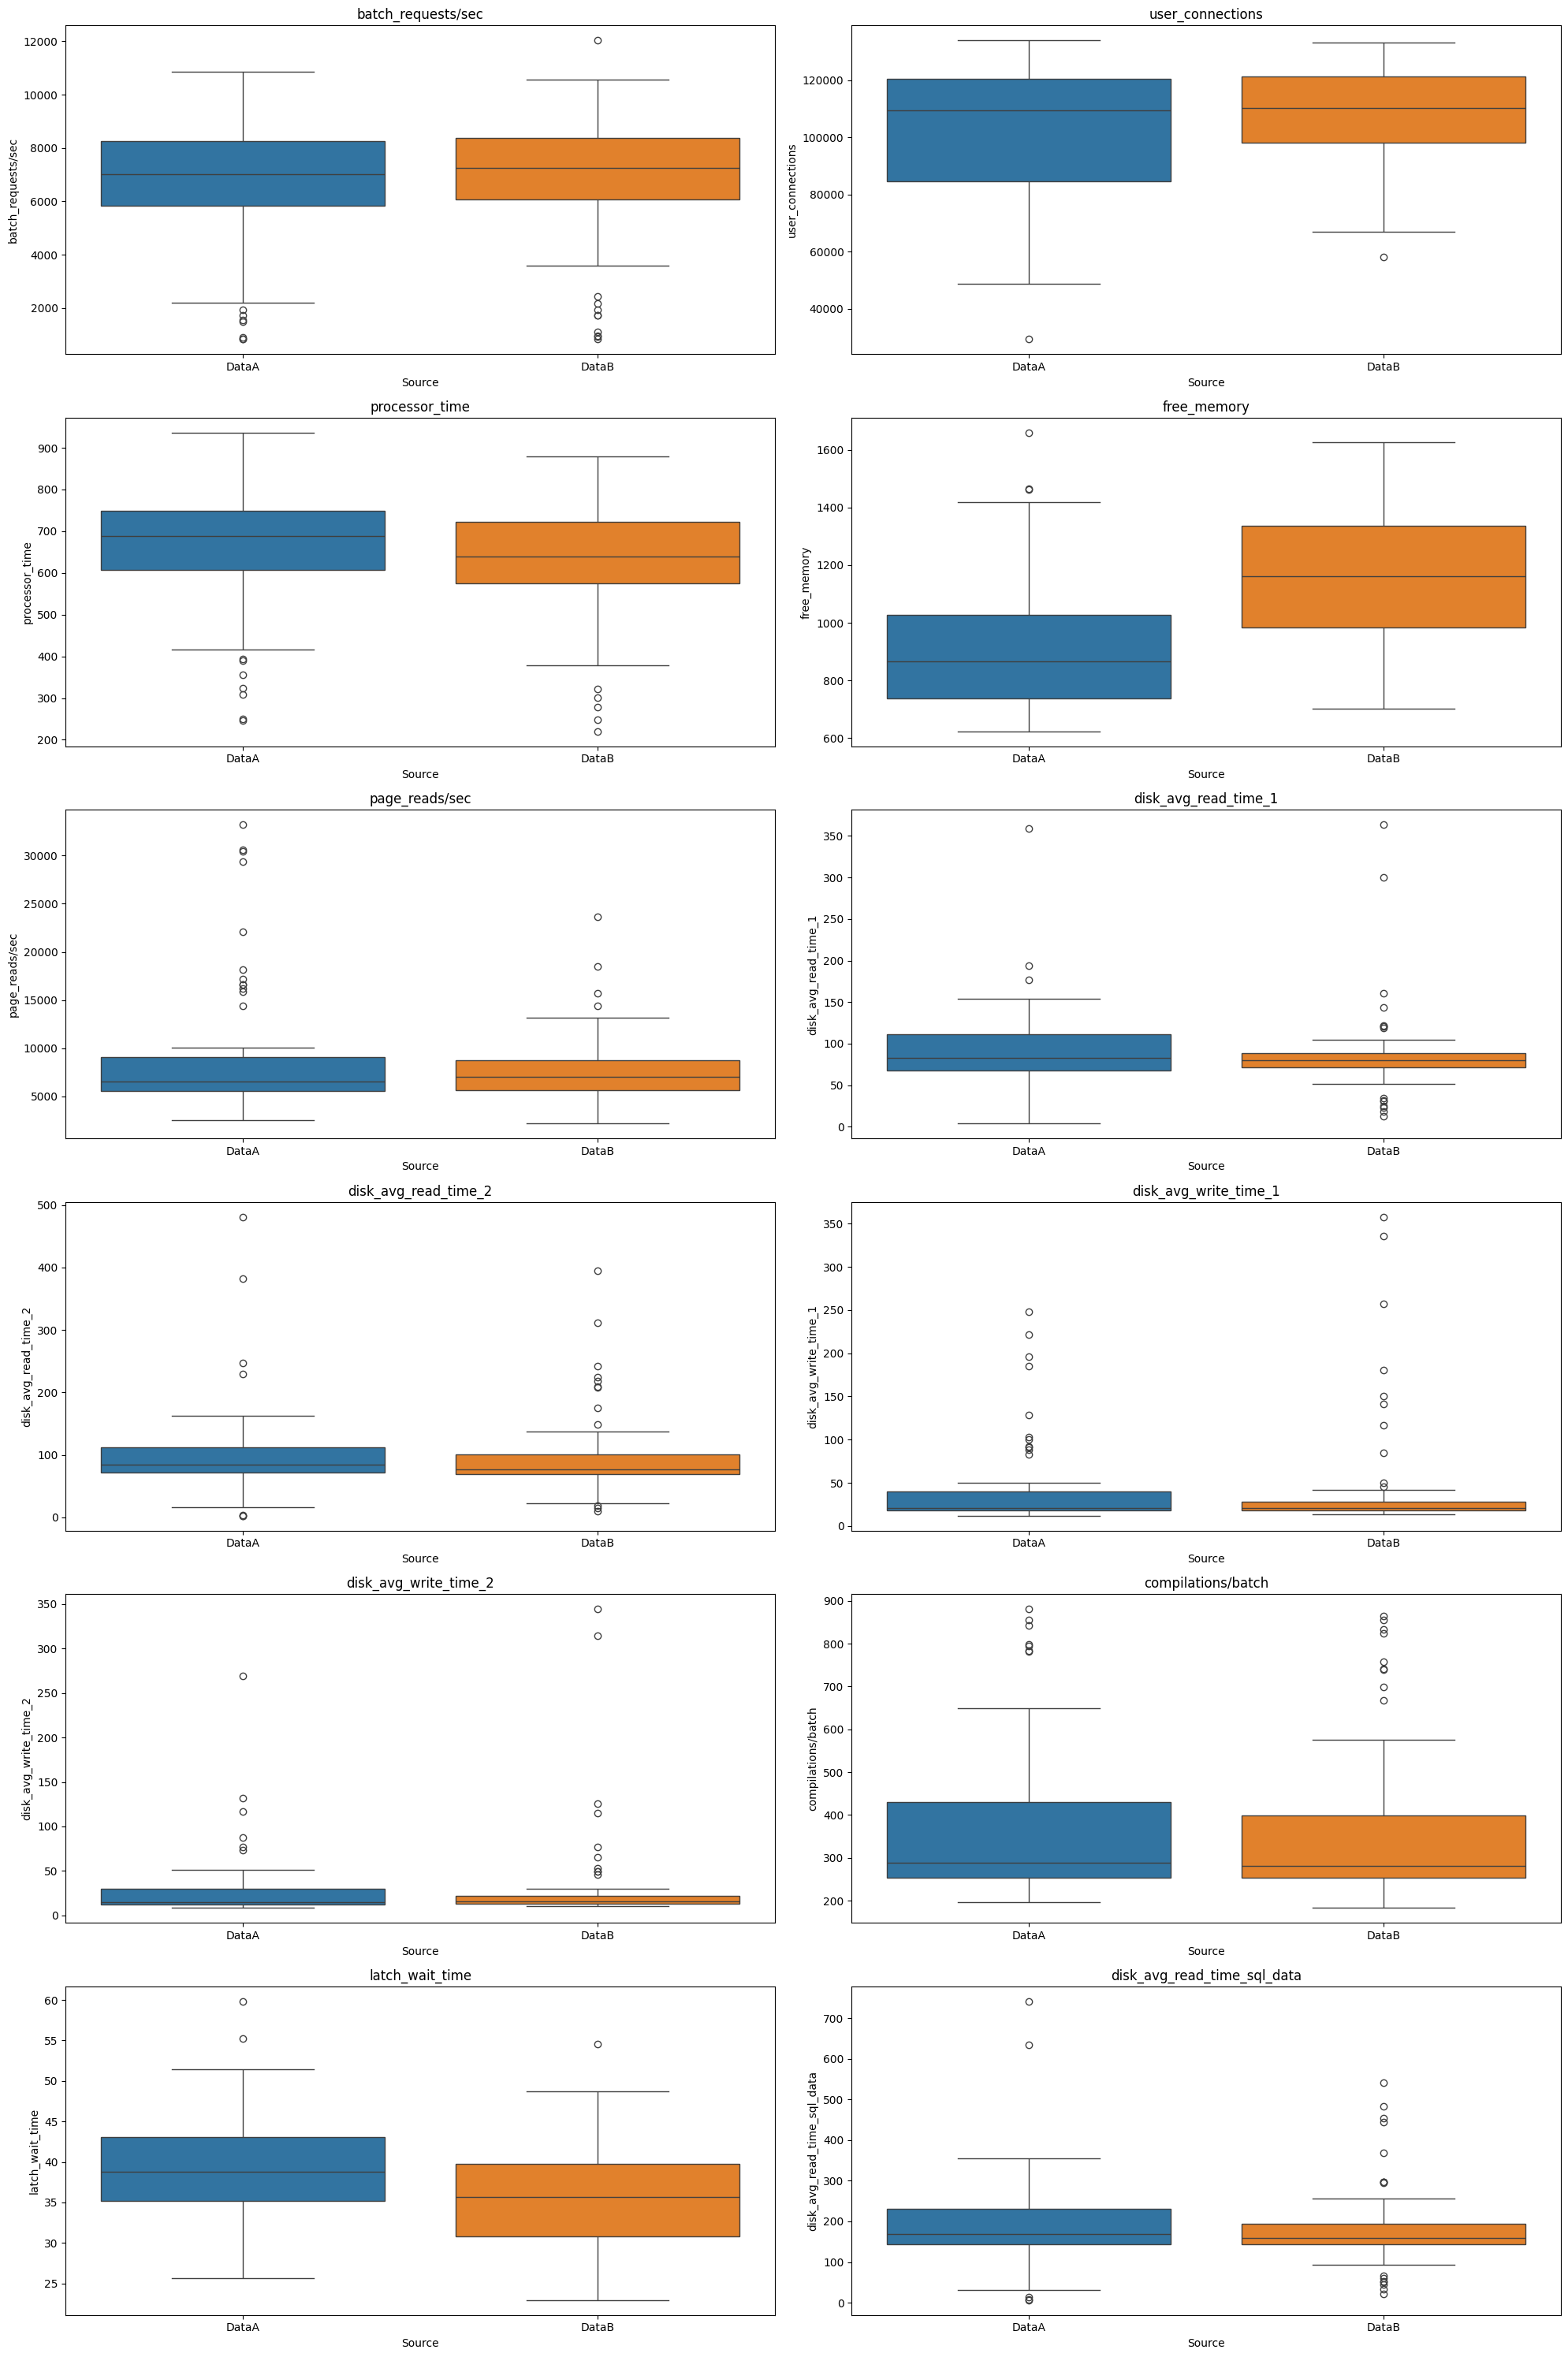

In [17]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 30))
axes = axes.flatten()

for i in range (len(dataA)):
    combined_df = pd.concat([dataA[i], dataB[i]])
    ax = axes[i]    
    sns.boxplot(data=combined_df, x='Source', y=combined_df.columns[1], ax = ax,hue='Source')
    ax.set_title(combined_df.columns[1])
plt.tight_layout()
plt.show()

### Processor time:
- Dataset A (blue) has a slightly higher median CPU usage compared to Dataset B (orange). Both datasets show similar ranges of central values, though Dataset A appears slightly more concentrated around its median.
- Dataset B shows a slightly wider spread overall, indicating a broader variability in CPU usage. Both datasets exhibit similar ranges for upper CPU usage, suggesting that peak CPU demand can be high in both scenarios regardless of maintenance status.

### Free memory:
- Dataset B (orange) has a higher median and a broader interquartile range of free memory compared to Dataset A (blue). This suggests that Dataset B generally maintains higher levels of available memory.
- Dataset B shows a wider overall spread, indicating greater variability in memory availability. Dataset A is more concentrated with a narrower range, reflecting a more consistent but generally lower memory usage pattern.

### Page read/ sec:
- Both Dataset A (blue) and Dataset B (orange) show similar medians, suggesting that the central tendency of page reads per second is comparable between both maintenance conditions. The interquartile ranges are also close, indicating a similar spread of typical read rates.
- Dataset A has more numerous and extreme upper outliers, indicating periods of significantly high read rates, which may be associated with maintenance activities or other processes that increase disk I/O. Dataset B also shows outliers, but these are less frequent and not as extreme, suggesting fewer disruptions that lead to high read rates.

### Disk average write time:
- Both datasets show comparable average read times, but Dataset B exhibits more extreme with a broader spread of outliers.
- The interquartile range (IQR) in Dataset B is smaller compared to Dataset A across all graphs, indicating that the middle 50% of read times in Dataset B are more tightly clustered around the median.
- Focus on Consistency: The smaller IQR suggests that even without maintenance, Dataset B is achieving a level of consistency within its central data points. This stability can be leveraged to predict more reliable performance during normal operations, allowing for more efficient resource allocation and planning.

### Disk average read time:

DataA shows a relatively consistent average read time with a median around 100 ms. The interquartile range (IQR) is narrow, indicating that most read times are fairly stable for DataA.
DataB, however, has a wider spread with multiple outliers, some of which go as high as 400 ms. This suggests that DataB has experienced significant fluctuations in read times, possibly indicating moments of high I/O demand or performance bottlenecks.
The higher number of outliers in DataB suggests less consistent disk read performance compared to DataA.

# Bivariate Analysis

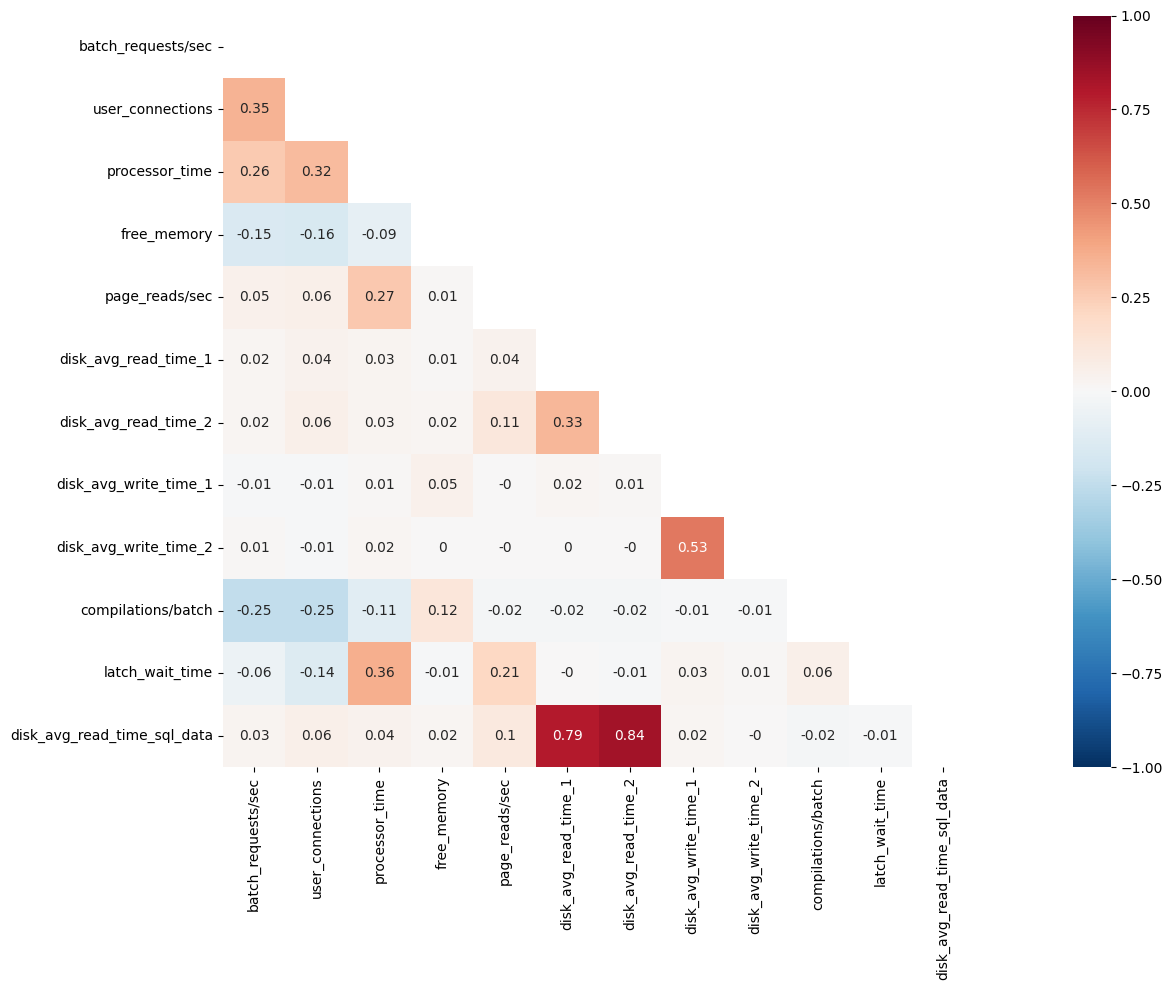

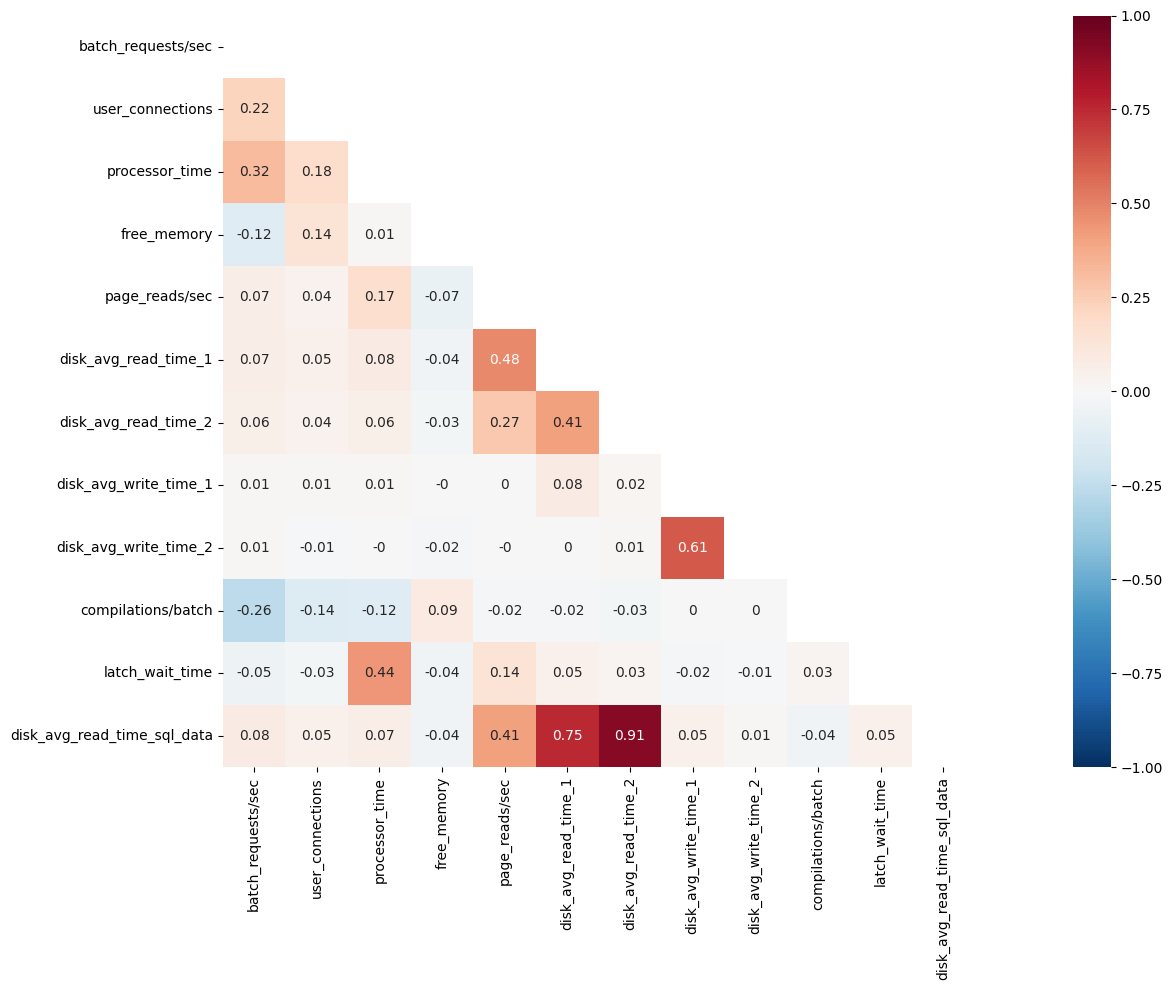

In [18]:
plt.figure(figsize=(20,10))
data_B_cor = round(data_B.drop(['date','date_hour','Source'], axis= 1).corr(),2)
mask = np.zeros_like(data_B_cor)
mask[np.triu_indices_from(mask)] =True
colormap = plt.cm.RdBu_r
heatmap = sns.heatmap(data_B_cor,vmin=-1, vmax= 1, annot = True, annot_kws={'size':10},mask=mask,square=True, cmap=colormap)
plt.tight_layout()

plt.figure(figsize=(20,10))
data_A_cor = round(data_A.drop(['date','date_hour','Source'], axis= 1).corr(),2)
mask = np.zeros_like(data_A_cor)
mask[np.triu_indices_from(mask)] =True
colormap = plt.cm.RdBu_r
heatmap = sns.heatmap(data_A_cor,vmin=-1, vmax= 1, annot = True, annot_kws={'size':10},mask=mask,square=True, cmap=colormap)
plt.tight_layout()

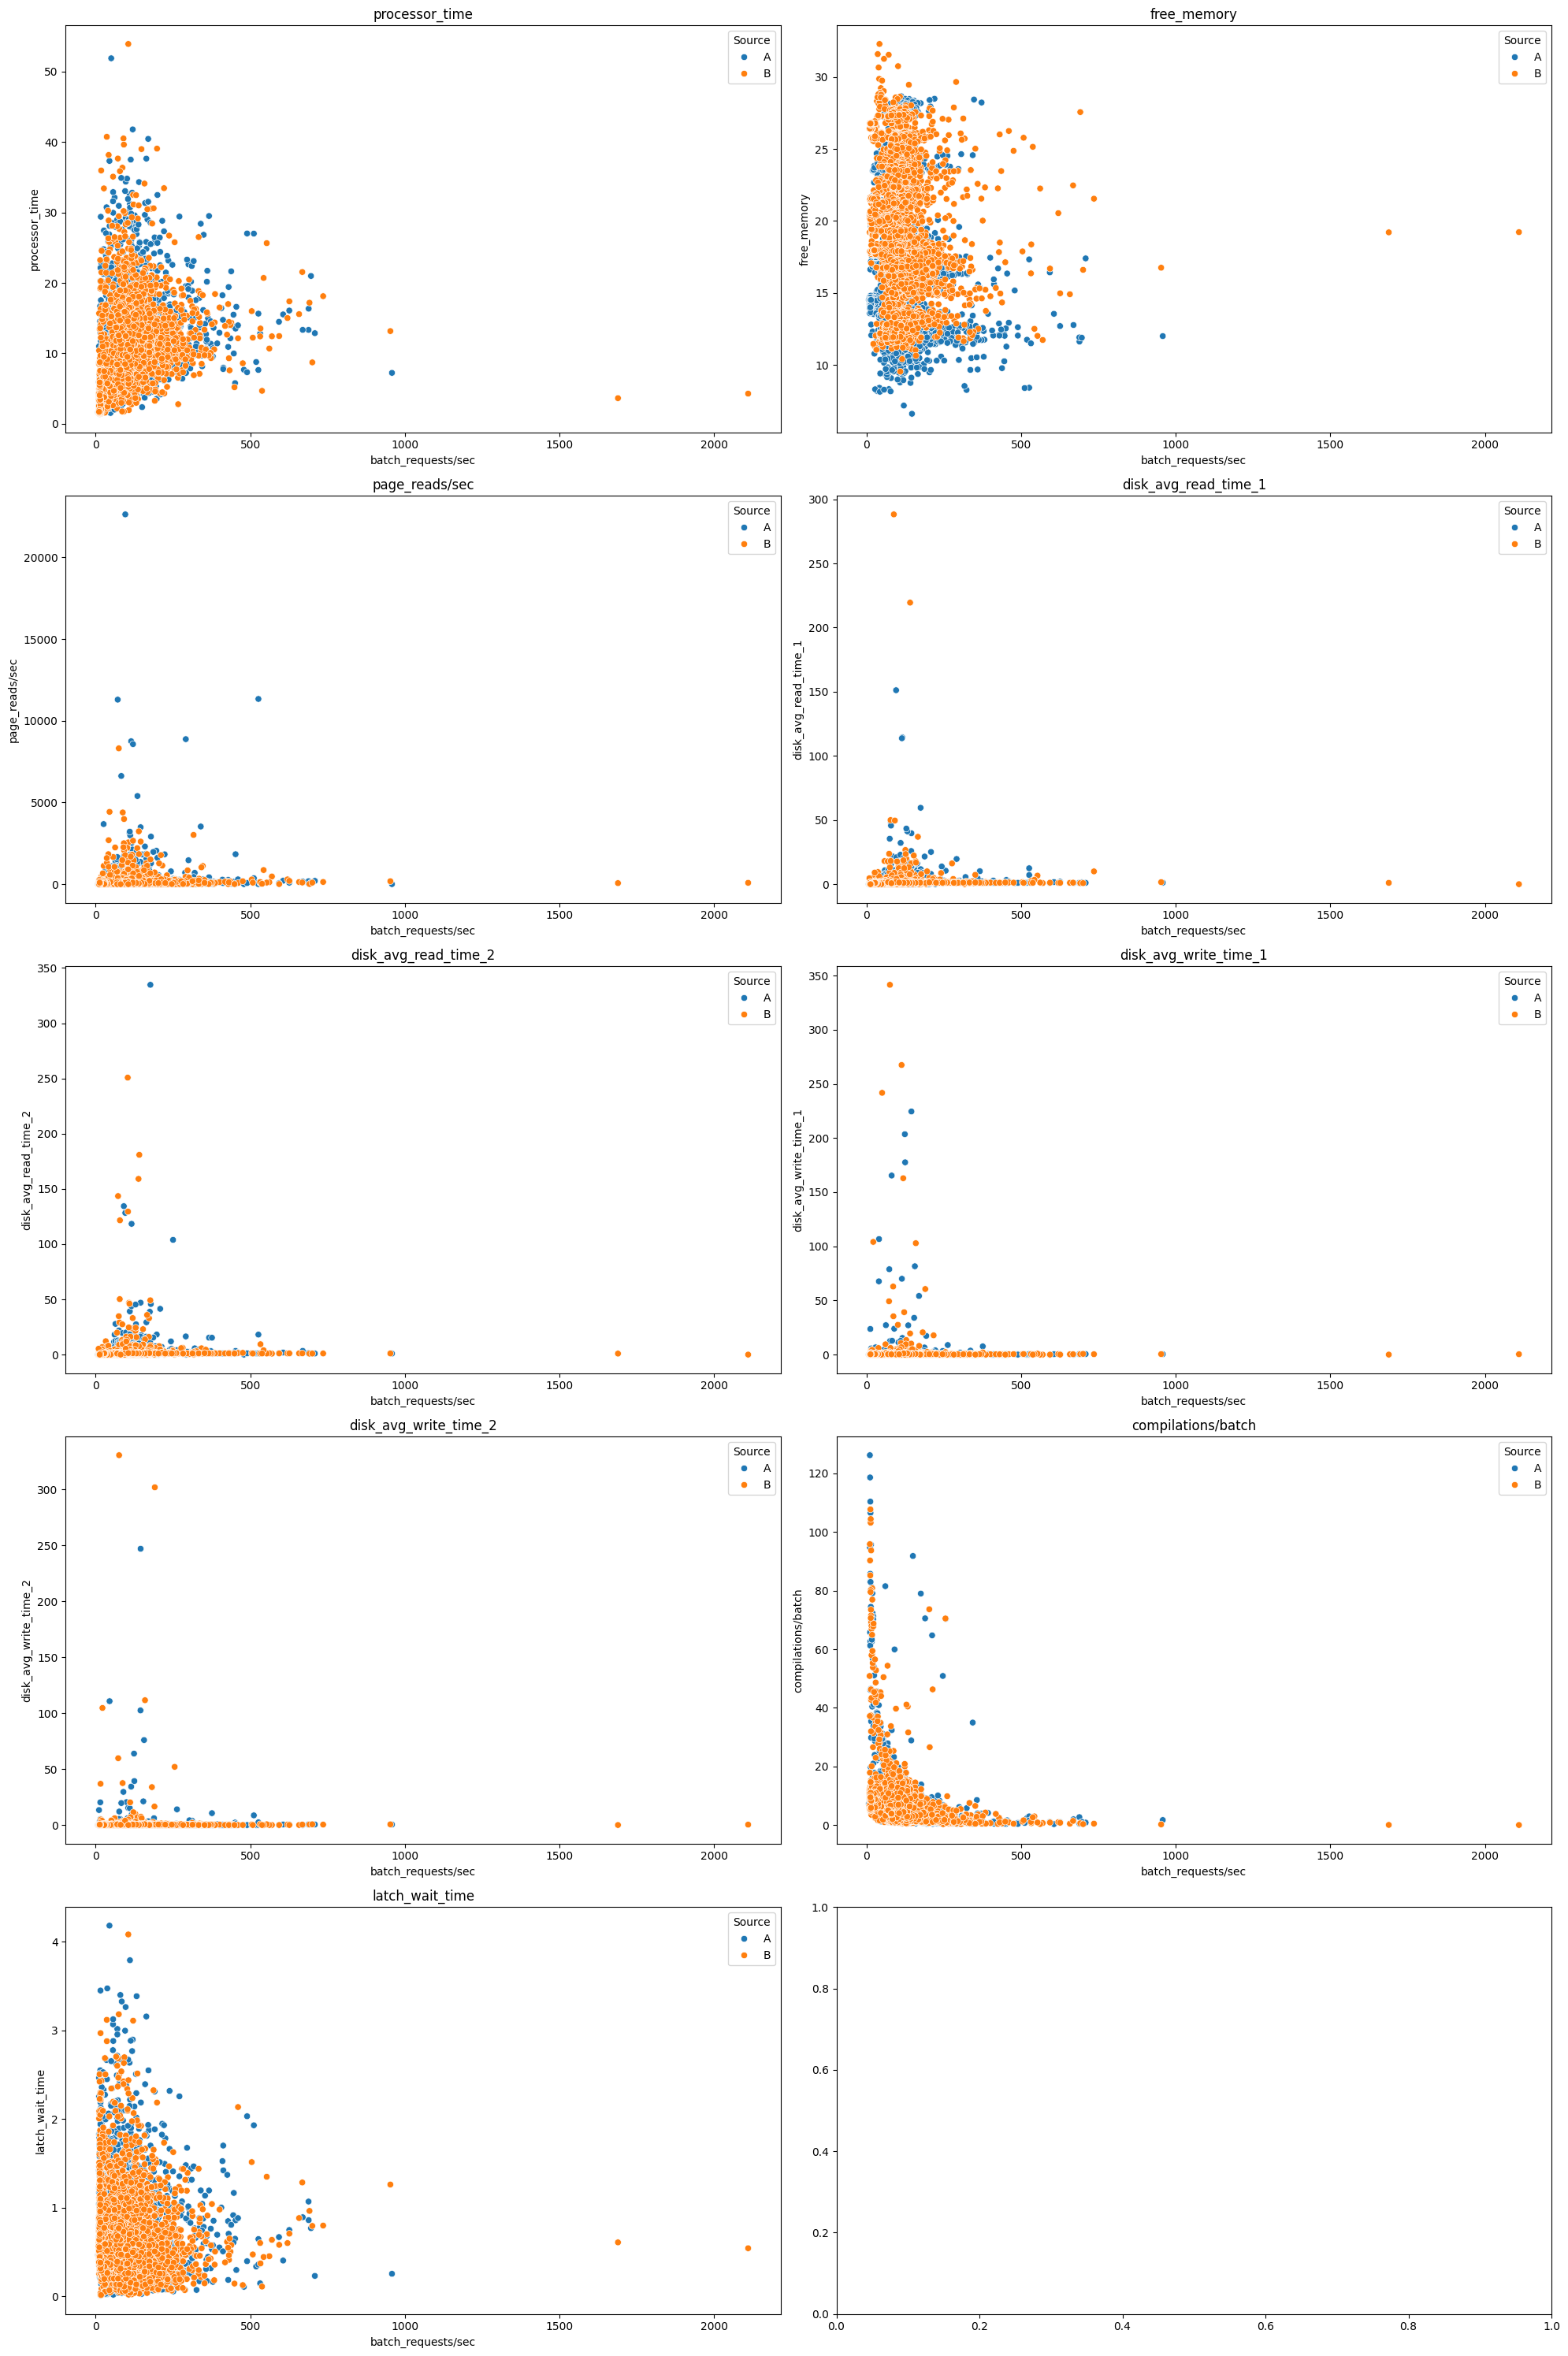

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

# Flatten the axes array for easy iteration
axes = axes.flatten()

combined_df = pd.concat([data_A, data_B]).reset_index()
# Plot each graph in a subplot
for i in range (4, len(data_A.columns)-2):
    ax = axes[i-4]
    
    # Create the boxplot with 'Source' as hue to differentiate
    sns.scatterplot(data=combined_df, x='batch_requests/sec', y=combined_df.columns[i], ax = ax,hue='Source')
    
    ax.set_title(combined_df.columns[i])


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()